<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "IT-L23"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/IT-L23/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


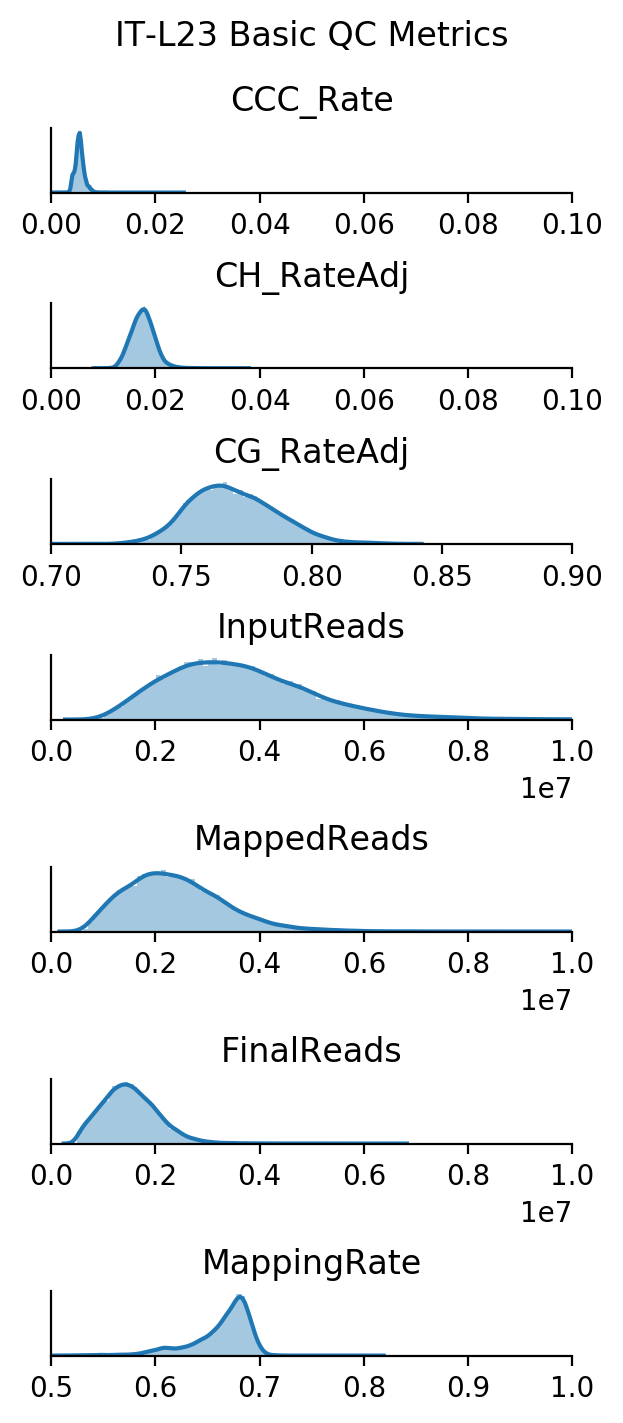

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

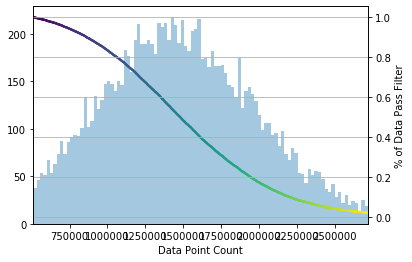

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 11919/11919 (100.0%)
CG_RateAdj passed 11919/11919 (100.0%)
CH_RateAdj passed 11919/11919 (100.0%)
FinalReads passed 11919/11919 (100.0%)
MappingRate passed 11919/11919 (100.0%)
Overall passed 11919/11919 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 241
171207 211
171212 48
171213 185
180104 222
180109 1
180110 1
180119 625
180122 306
180123 314
180129 323
180130 266
180205 263
180206 276
180208 15
180212 21
180213 693
180220 67
180222 52
180226 660
180227 486
180305 198
180306 212
180312 254
180313 8
180319 9
180320 69
180326 59
180329 32
180402 26
180403 18
180405 3
180409 399
180410 294
180412 168
180416 251
180417 213
180419 181
180423 192
180424 163
180426 224
180430 210
180501 193
180514 148
180529 209
180605 140
180612 216
180917 2
181002 164
181008 3
181009 40
181022 235
181023 192
181204 4
181210 162
190108 347
190117 354
190122 186
190124 185
190131 50
190205 358
190214 1
190219 1
190305 1
190307 269


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 1469 382.6%
ad002 1463 381.0%
ad004 1426 371.4%
ad006 1541 401.3%
ad007 1522 396.4%
ad008 1461 380.5%
ad010 1464 381.2%
ad012 1573 409.6%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
11F_M_2246,/gale/raidix/rdx-4/mapping/11F/CEMBA190305-11F...,0.005375,0.774533,0.773314,0.021831,0.016545,2280295.0,5471290,3773628.0,11F,...,-19.422514,-27.520639,-29.470852,-29.005648,IT-L23,-1.705346,-12.695367,-13.331906,52.938001,True
11F_M_249,/gale/raidix/rdx-4/mapping/11F/CEMBA190214-11F...,0.005430,0.767669,0.766401,0.019748,0.014396,986794.0,2213184,1481571.0,11F,...,-14.302521,-30.662601,-12.164972,-21.240975,IT-L23,5.941688,-12.173076,-4.373414,13.679977,True
1A_M_10,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004260,0.777700,0.776750,0.019680,0.015490,2339654.0,5217724,3577060.0,1A,...,-20.063660,-26.146975,-32.704911,-31.905302,IT-L23,-1.063168,-9.174500,-31.040546,35.281430,True
1A_M_100,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004250,0.763680,0.762670,0.018550,0.014360,2353156.0,5552334,3742394.0,1A,...,-21.077007,-26.378529,-32.915180,-33.962880,IT-L23,-3.020821,-8.754897,-34.883689,40.099554,True
1A_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004500,0.767620,0.766570,0.022590,0.018170,772646.0,1686646,1142296.0,1A,...,-18.079884,-28.982473,-19.575323,-29.933153,IT-L23,1.270407,-11.740139,-7.461481,38.085817,True
1A_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004160,0.744950,0.743880,0.019560,0.015460,1207422.0,2472356,1706216.0,1A,...,-20.774635,-26.843412,-31.616008,-33.545429,IT-L23,-1.953783,-9.708794,-31.915357,37.388974,True
1A_M_1006,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.003970,0.768150,0.767230,0.018920,0.015010,1098249.0,2331320,1583937.0,1A,...,-16.605783,-28.802824,-20.969341,-25.826221,IT-L23,2.778194,-11.763122,-8.608512,33.900815,True
1A_M_1008,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004170,0.756720,0.755700,0.020670,0.016570,1050731.0,2327180,1556454.0,1A,...,-19.421761,-27.563107,-29.388524,-31.372923,IT-L23,-0.762671,-10.388048,-22.757344,39.881057,True
1A_M_101,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004510,0.766610,0.765550,0.021280,0.016850,1907035.0,4665514,3093693.0,1A,...,-18.708889,-27.954435,-24.482816,-29.771494,IT-L23,0.281269,-11.081157,-12.858826,37.785150,True
